In [ ]:
# Cell 1: Data Loading and Merging
# Place this cell at the top of your notebook.
# If your data files are not in 'data/', update the paths accordingly.

import pandas as pd

# Update these paths if your data is elsewhere!
train_path = r'D:\GITHUB\New folder\sales forecasting\data\Data\train.csv'      # CHANGE PATH IF NEEDED
stores_path = r'D:\GITHUB\New folder\sales forecasting\data\Data\stores.csv'    # CHANGE PATH IF NEEDED
features_path = r'D:\GITHUB\New folder\sales forecasting\data\Data\features.csv' # CHANGE PATH IF NEEDED

# Load data
train_df = pd.read_csv(train_path)
stores_df = pd.read_csv(stores_path)
features_df = pd.read_csv(features_path)

# Merge train with stores on 'Store'
merged_df = pd.merge(train_df, stores_df, on='Store', how='left')

# Merge with features on ['Store', 'Date']
merged_df = pd.merge(merged_df, features_df, on=['Store', 'Date'], how='left')

print("Shape after merge:", merged_df.shape)
merged_df.head()



Shape after merge: (421570, 17)


,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [ ]:
# Data Preprocessing: Datetime conversion, sorting, feature extraction, missing values
# Add this cell after your data loading & merging cell in the notebook

import numpy as np

# Convert 'Date' to datetime
merged_df['Date'] = pd.to_datetime(merged_df['Date'])

# Sort chronologically for time series modeling
merged_df = merged_df.sort_values(['Store', 'Dept', 'Date']).reset_index(drop=True)

# Extract temporal features
merged_df['Year'] = merged_df['Date'].dt.year
merged_df['Month'] = merged_df['Date'].dt.month
merged_df['Week'] = merged_df['Date'].dt.isocalendar().week
merged_df['DayOfWeek'] = merged_df['Date'].dt.dayofweek  # Monday=0

# Check missing values
missing_summary = merged_df.isnull().sum().sort_values(ascending=False)
print("Missing values summary:\n", missing_summary.head(10))

Missing values summary:
 MarkDown2       310322
MarkDown4       286603
MarkDown3       284479
MarkDown1       270889
MarkDown5       270138
Week                 0
Month                0
Year                 0
IsHoliday_y          0
Unemployment         0
dtype: int64


In [ ]:
# Missing Value Imputation for MarkDown features
# Place this cell after your previous preprocessing cell

markdown_cols = [col for col in merged_df.columns if 'MarkDown' in col]
merged_df[markdown_cols] = merged_df[markdown_cols].fillna(0)

# Confirm imputation
print(merged_df[markdown_cols].isnull().sum())

MarkDown1    0
MarkDown2    0
MarkDown3    0
MarkDown4    0
MarkDown5    0
dtype: int64


In [ ]:
# Temporal Feature Engineering: Holidays and IsHoliday
# Place this cell directly after your missing value imputation cell.

# --- Handle the IsHoliday column after merges ---
# If both IsHoliday_x and IsHoliday_y exist, keep only IsHoliday_y (from features.csv)
if 'IsHoliday_x' in merged_df.columns:
    merged_df.drop('IsHoliday_x', axis=1, inplace=True)
if 'IsHoliday' in merged_df.columns and 'IsHoliday_y' in merged_df.columns:
    merged_df.drop('IsHoliday', axis=1, inplace=True)

# Rename IsHoliday_y to IsHoliday if needed
if 'IsHoliday_y' in merged_df.columns:
    merged_df.rename(columns={'IsHoliday_y': 'IsHoliday'}, inplace=True)

# Convert IsHoliday to boolean (in case it's not already)
merged_df['IsHoliday'] = merged_df['IsHoliday'].astype(bool)

# --- Major Holiday Flags ---
# List of key holiday dates as per Walmart dataset documentation
major_holidays = {
    'Super_Bowl': ['2010-02-12', '2011-02-11', '2012-02-10', '2013-02-08'],
    'Labor_Day': ['2010-09-10', '2011-09-09', '2012-09-07', '2013-09-06'],
    'Thanksgiving': ['2010-11-26', '2011-11-25', '2012-11-23', '2013-11-22'],
    'Christmas': ['2010-12-31', '2011-12-30', '2012-12-28', '2013-12-27']
}

# Add a binary flag column for each major holiday
for holiday, dates in major_holidays.items():
    flag_col = f"{holiday}_Flag"
    merged_df[flag_col] = merged_df['Date'].isin(pd.to_datetime(dates)).astype(int)

# Add WeekOfYear feature (seasonality)
merged_df['WeekOfYear'] = merged_df['Date'].dt.isocalendar().week

# Show a preview of the new columns
example_cols = [
    'Date', 'IsHoliday', 'Super_Bowl_Flag', 'Labor_Day_Flag',
    'Thanksgiving_Flag', 'Christmas_Flag', 'WeekOfYear'
]
print(merged_df[example_cols].head(10))

        Date  IsHoliday  Super_Bowl_Flag  Labor_Day_Flag  Thanksgiving_Flag  \
0 2010-02-05      False                0               0                  0   
1 2010-02-12       True                1               0                  0   
2 2010-02-19      False                0               0                  0   
3 2010-02-26      False                0               0                  0   
4 2010-03-05      False                0               0                  0   
5 2010-03-12      False                0               0                  0   
6 2010-03-19      False                0               0                  0   
7 2010-03-26      False                0               0                  0   
8 2010-04-02      False                0               0                  0   
9 2010-04-09      False                0               0                  0   

   Christmas_Flag  WeekOfYear  
0               0           5  
1               0           6  
2               0           7  
3 

In [ ]:
# Categorical Encoding for relevant columns (e.g., Type, possibly others)
# Place this cell after your temporal/holiday feature engineering cell

from sklearn.preprocessing import LabelEncoder

# Identify categorical columns (update as needed)
cat_cols = []
if 'Type' in merged_df.columns:
    cat_cols.append('Type')
if 'Store' in merged_df.columns and merged_df['Store'].dtype == object:
    cat_cols.append('Store')
if 'Dept' in merged_df.columns and merged_df['Dept'].dtype == object:
    cat_cols.append('Dept')

# Fill missing in categorical columns with a placeholder
for col in cat_cols:
    merged_df[col] = merged_df[col].fillna('Unknown')

# Label encode each categorical column
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    merged_df[col] = le.fit_transform(merged_df[col])
    label_encoders[col] = le  # Save for future use (e.g., on test data)

print("Categorical columns encoded:", cat_cols)
print(merged_df[cat_cols].head(10))

Categorical columns encoded: ['Type']
   Type
0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0


In [ ]:
# Lag Features and Moving Averages for Weekly Sales
# Place this cell after categorical encoding

# We'll engineer lag features and moving averages for Weekly_Sales, grouped by Store and Dept

# Number of lag periods and window sizes for rolling averages
lag_periods = [1, 2, 3]  # 1, 2, and 3 weeks ago
ma_windows = [3, 5, 8]   # 3, 5, and 8 week rolling averages

# Create lag features
for lag in lag_periods:
    merged_df[f'Weekly_Sales_Lag_{lag}'] = (
        merged_df
        .groupby(['Store', 'Dept'])['Weekly_Sales']
        .shift(lag)
    )

# Create moving average features
for window in ma_windows:
    merged_df[f'Weekly_Sales_MA_{window}'] = (
        merged_df
        .groupby(['Store', 'Dept'])['Weekly_Sales']
        .transform(lambda x: x.shift(1).rolling(window=window, min_periods=1).mean())
    )

# Check the feature output
lag_ma_cols = [f'Weekly_Sales_Lag_{lag}' for lag in lag_periods] + \
              [f'Weekly_Sales_MA_{window}' for window in ma_windows]
print(merged_df[lag_ma_cols + ['Weekly_Sales']].head(10))

   Weekly_Sales_Lag_1  Weekly_Sales_Lag_2  Weekly_Sales_Lag_3  \
0                 NaN                 NaN                 NaN   
1            24924.50                 NaN                 NaN   
2            46039.49            24924.50                 NaN   
3            41595.55            46039.49            24924.50   
4            19403.54            41595.55            46039.49   
5            21827.90            19403.54            41595.55   
6            21043.39            21827.90            19403.54   
7            22136.64            21043.39            21827.90   
8            26229.21            22136.64            21043.39   
9            57258.43            26229.21            22136.64   

   Weekly_Sales_MA_3  Weekly_Sales_MA_5  Weekly_Sales_MA_8  Weekly_Sales  
0                NaN                NaN                NaN      24924.50  
1       24924.500000       24924.500000       24924.500000      46039.49  
2       35481.995000       35481.995000       35481.995000 

In [ ]:
# MarkDown Activity Flags
# Place this cell after lag/moving average feature engineering.

markdown_cols = [col for col in merged_df.columns if 'MarkDown' in col and not col.endswith('_Flag')]
for col in markdown_cols:
    flag_col = col + '_Flag'
    merged_df[flag_col] = (merged_df[col] > 0).astype(int)

# Preview the new flag columns
flag_preview_cols = [col for col in merged_df.columns if col.endswith('_Flag')]
print(merged_df[flag_preview_cols].head(10))



   Super_Bowl_Flag  Labor_Day_Flag  Thanksgiving_Flag  Christmas_Flag  \
0                0               0                  0               0   
1                1               0                  0               0   
2                0               0                  0               0   
3                0               0                  0               0   
4                0               0                  0               0   
5                0               0                  0               0   
6                0               0                  0               0   
7                0               0                  0               0   
8                0               0                  0               0   
9                0               0                  0               0   

   MarkDown1_Flag  MarkDown2_Flag  MarkDown3_Flag  MarkDown4_Flag  \
0               0               0               0               0   
1               0               0               0         

In [ ]:
# Target Quota and Quota Deviation Calculation
# Place this cell after MarkDown flag engineering

QUOTA_BUFFER = 0.05  # 5% buffer above historical mean (adjust as needed)

# Compute historical mean sales for each Store-Dept pair (using all available data)
store_dept_mean = (
    merged_df
    .groupby(['Store', 'Dept'])['Weekly_Sales']
    .transform('mean')
)

# Apply buffer to set the quota
merged_df['Quota'] = store_dept_mean * (1 + QUOTA_BUFFER)

# Compute deviation (actual sales - quota)
merged_df['Quota_Deviation'] = merged_df['Weekly_Sales'] - merged_df['Quota']

# Preview
print(merged_df[['Store', 'Dept', 'Date', 'Weekly_Sales', 'Quota', 'Quota_Deviation']].head(10))



   Store  Dept       Date  Weekly_Sales         Quota  Quota_Deviation
0      1     1 2010-02-05      24924.50  23638.989084      1285.510916
1      1     1 2010-02-12      46039.49  23638.989084     22400.500916
2      1     1 2010-02-19      41595.55  23638.989084     17956.560916
3      1     1 2010-02-26      19403.54  23638.989084     -4235.449084
4      1     1 2010-03-05      21827.90  23638.989084     -1811.089084
5      1     1 2010-03-12      21043.39  23638.989084     -2595.599084
6      1     1 2010-03-19      22136.64  23638.989084     -1502.349084
7      1     1 2010-03-26      26229.21  23638.989084      2590.220916
8      1     1 2010-04-02      57258.43  23638.989084     33619.440916
9      1     1 2010-04-09      42960.91  23638.989084     19321.920916


In [ ]:
# Time-Aware Train/Test Split (for time series validation)
# Place this cell after quota calculation

# Define your cutoff date (adjust as needed)
split_date = pd.to_datetime('2012-01-01')

train_df = merged_df[merged_df['Date'] < split_date].reset_index(drop=True)
test_df  = merged_df[merged_df['Date'] >= split_date].reset_index(drop=True)

print("Train set shape:", train_df.shape)
print("Test set shape:", test_df.shape)
print("Train date range:", train_df['Date'].min(), "to", train_df['Date'].max())
print("Test date range:", test_df['Date'].min(), "to", test_df['Date'].max())



Train set shape: (294132, 38)
Test set shape: (127438, 38)
Train date range: 2010-02-05 00:00:00 to 2011-12-30 00:00:00
Test date range: 2012-01-06 00:00:00 to 2012-10-26 00:00:00


In [ ]:
# Baseline Random Forest Regressor for Weekly Sales
# Remove rows with missing values in features or target before fitting/scoring the model

# Identify columns to drop (target, date, quota, etc. — not features!)
drop_cols = ['Date', 'Weekly_Sales', 'Quota', 'Quota_Deviation']

# Features to use for modeling
feature_cols = [col for col in train_df.columns if col not in drop_cols]

# Build X and y for train/test
X_train = train_df[feature_cols]
y_train = train_df['Weekly_Sales']
X_test = test_df[feature_cols]
y_test = test_df['Weekly_Sales']

# Drop rows with any NaNs in features or target
train_mask = X_train.notna().all(axis=1) & y_train.notna()
test_mask = X_test.notna().all(axis=1) & y_test.notna()
X_train_clean = X_train[train_mask]
y_train_clean = y_train[train_mask]
X_test_clean = X_test[test_mask]
y_test_clean = y_test[test_mask]

print(f"Train set after NaN removal: {X_train_clean.shape}, Test set: {X_test_clean.shape}")

# Fit model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train_clean, y_train_clean)

# Predict & evaluate
y_pred = rf.predict(X_test_clean)
rmse = np.sqrt(mean_squared_error(y_test_clean, y_pred))
print(f"Test RMSE: {rmse:,.2f}")

Train set after NaN removal: (284342, 34), Test set: (127339, 34)
Test RMSE: 3,318.35


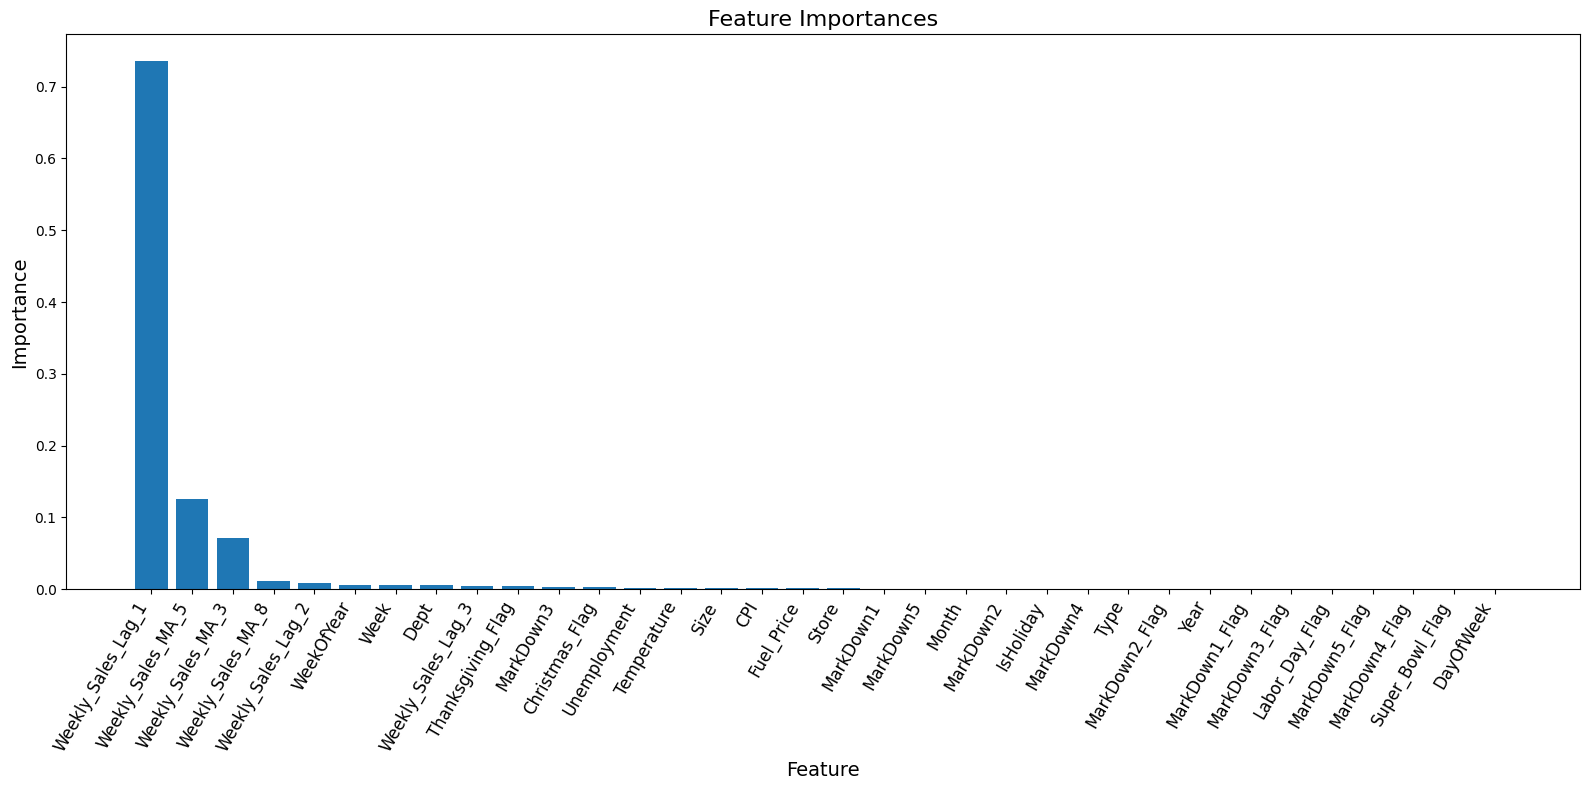

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'rf' is your trained model and 'feature_cols' is your list of feature names
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(16, 8))  # Increased size for better detail

plt.title("Feature Importances", fontsize=16)
plt.bar(range(len(feature_cols)), importances[indices], align="center")
plt.xticks(
    range(len(feature_cols)),
    [feature_cols[i] for i in indices],
    rotation=60,
    ha='right',
    fontsize=12
)
plt.ylabel("Importance", fontsize=14)
plt.xlabel("Feature", fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# Add predictions and residuals to test_df
test_valid = test_df.loc[test_mask].copy()
test_valid['Predicted_Weekly_Sales'] = y_pred
test_valid['Residual'] = test_valid['Weekly_Sales'] - test_valid['Predicted_Weekly_Sales']

# Quick summary statistics
print(test_valid[['Residual']].describe())

           Residual
count  127339.00000
mean     -338.69745
std      3301.03271
min    -76496.27500
25%      -936.13265
50%      -127.89980
75%       270.43945
max    100816.19790


c:\Users\ASUS ROG\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


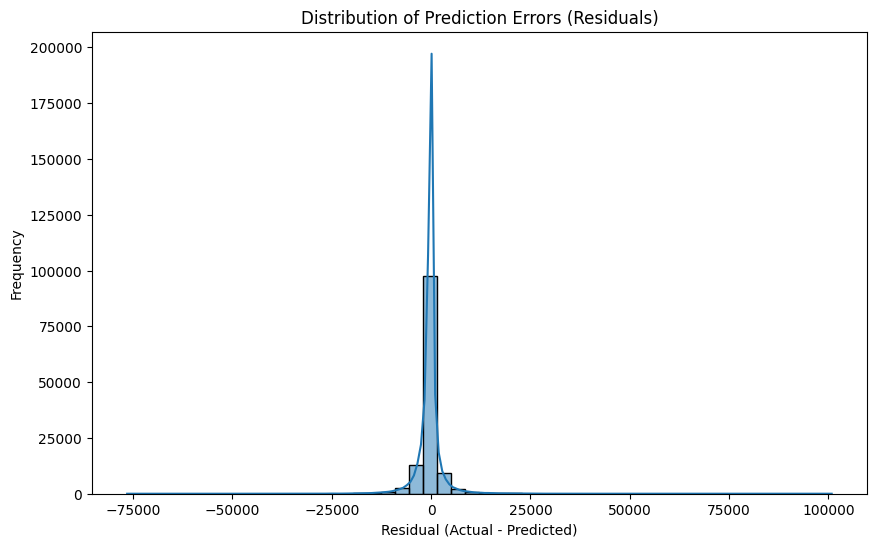

In [ ]:
#Visualize Error Distribution
import seaborn as sns

plt.figure(figsize=(10,6))
sns.histplot(test_valid['Residual'], bins=50, kde=True)
plt.title('Distribution of Prediction Errors (Residuals)')
plt.xlabel('Residual (Actual - Predicted)')
plt.ylabel('Frequency')
plt.show()

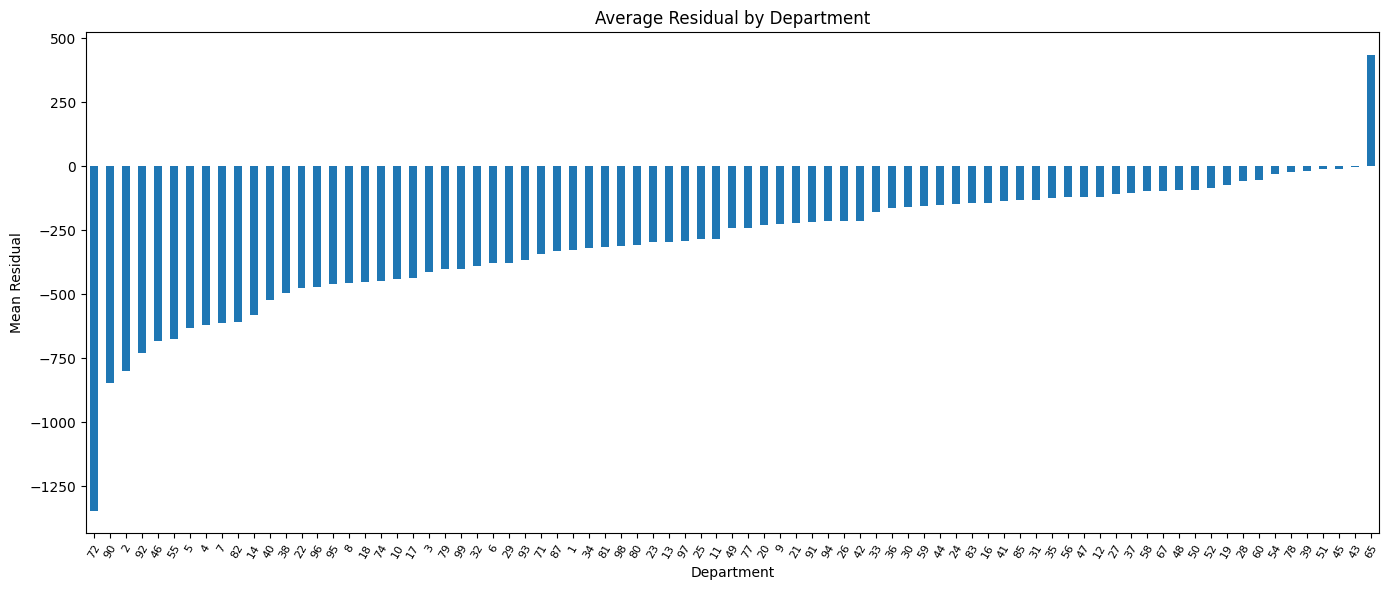

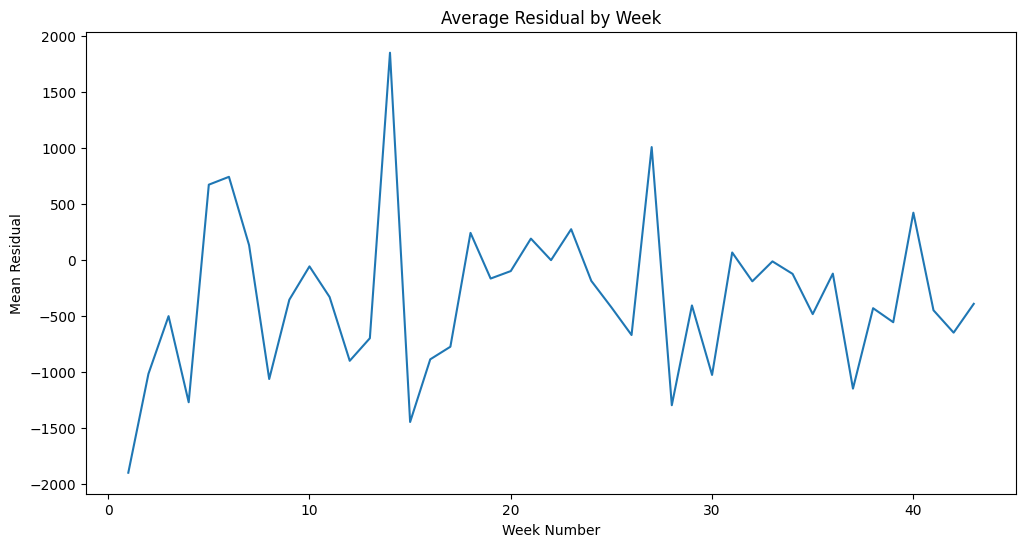

In [ ]:
#Investigating Error by Key Groups
# By Department
plt.figure(figsize=(14,6))
ax = dept_errors.plot(kind='bar')
plt.title('Average Residual by Department')
plt.ylabel('Mean Residual')
plt.xlabel('Department')
plt.xticks(fontsize=8, rotation=60)  # Make x labels smaller and angled
plt.tight_layout()
plt.show()

# By Week (or Date)
test_valid['Week'] = test_valid['Date'].dt.isocalendar().week
weekly_errors = test_valid.groupby('Week')['Residual'].mean()
plt.figure(figsize=(12,6))
weekly_errors.plot()
plt.title('Average Residual by Week')
plt.ylabel('Mean Residual')
plt.xlabel('Week Number')
plt.show()

In [ ]:
#   training XGboost on the same data
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np

# XGBoost requires numpy arrays
X_train_np = X_train_clean.values
y_train_np = y_train_clean.values
X_test_np = X_test_clean.values
y_test_np = y_test_clean.values

# Train XGBoost regressor
xgb_model = xgb.XGBRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    n_jobs=-1,
    tree_method='hist'  # 'hist' is fast and handles NaN (if any remain)
)
xgb_model.fit(X_train_np, y_train_np)

# Predict & evaluate
y_pred_xgb = xgb_model.predict(X_test_np)
rmse_xgb = np.sqrt(mean_squared_error(y_test_np, y_pred_xgb))
print(f"XGBoost Test RMSE: {rmse_xgb:,.2f}")

XGBoost Test RMSE: 3,258.66


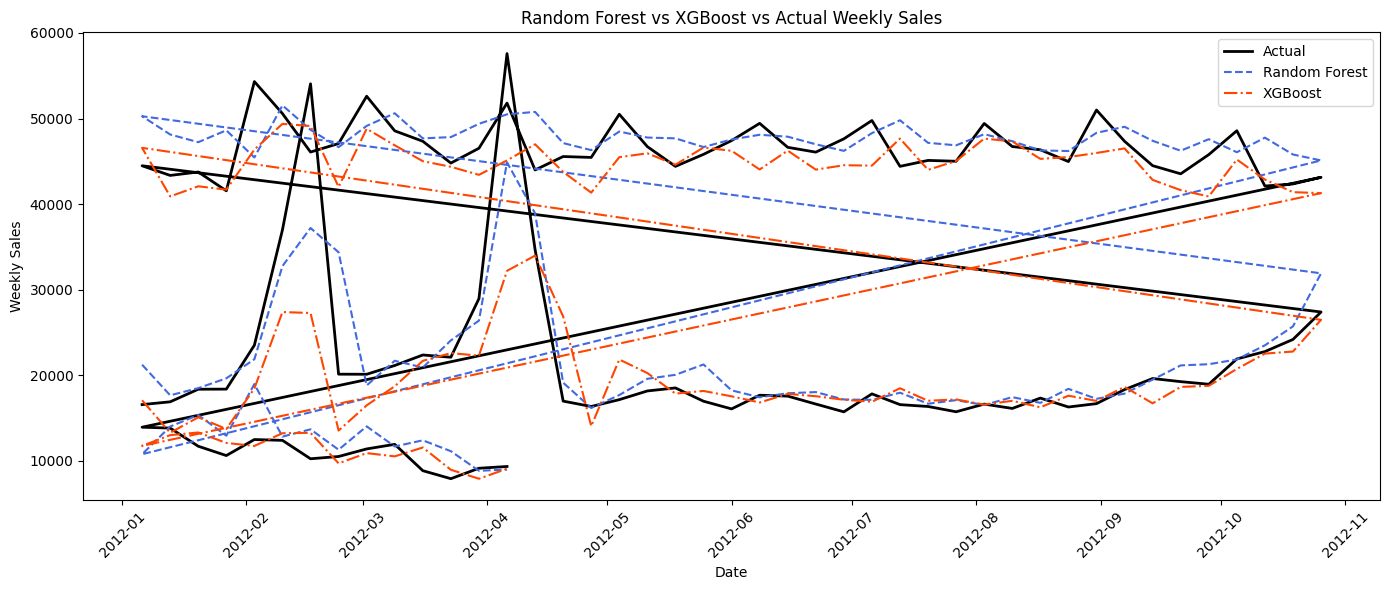

In [ ]:
#comparing Random Forest, XGBoost, and actual values
# Select a subset for clarity (e.g., first 100 predictions)
n = 100
plot_dates = test_valid['Date'].iloc[:n]
actual = test_valid['Weekly_Sales'].iloc[:n]
rf_pred = test_valid['Predicted_Weekly_Sales'].iloc[:n]
xgb_pred = y_pred_xgb[:n]  # from your previous XGBoost prediction (make sure ordering matches!)

plt.figure(figsize=(14, 6))
plt.plot(plot_dates, actual, label='Actual', color='black', linewidth=2)
plt.plot(plot_dates, rf_pred, label='Random Forest', linestyle='--', color='royalblue')
plt.plot(plot_dates, xgb_pred, label='XGBoost', linestyle='-.', color='orangered')
plt.title('Random Forest vs XGBoost vs Actual Weekly Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45, fontsize=10)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
print("="*50)
print("📊 PROJECT SUMMARY")
print("="*50)
print(f"Train set size (after NaN removal): {X_train_clean.shape}")
print(f"Test set size (after NaN removal): {X_test_clean.shape}")
print("\nModels & Performance:")
print("-" * 30)
print(f"Random Forest RMSE: {rmse:,.2f}")
print(f"XGBoost RMSE: {rmse_xgb:,.2f}")
print("\nTop Features (by importance):")
top_features = [feature_cols[i] for i in np.argsort(rf.feature_importances_)[::-1][:5]]
print(", ".join(top_features))
print("\nKey Steps:")
print("- Feature engineering: Created lag and moving average features.")
print("- NaN handling: Dropped rows with missing data before modeling.")
print("- Model comparison: Evaluated Random Forest and XGBoost.")
print("- Residual analysis: Visualized errors by department and overall.")
print("- Feature importance: Plotted and interpreted model importances.")
print("="*50)



📊 PROJECT SUMMARY
Train set size (after NaN removal): (284342, 34)
Test set size (after NaN removal): (127339, 34)

Models & Performance:
------------------------------
Random Forest RMSE: 3,318.35
XGBoost RMSE: 3,258.66

Top Features (by importance):
Weekly_Sales_Lag_1, Weekly_Sales_MA_5, Weekly_Sales_MA_3, Weekly_Sales_MA_8, Weekly_Sales_Lag_2

Key Steps:
- Feature engineering: Created lag and moving average features.
- NaN handling: Dropped rows with missing data before modeling.
- Model comparison: Evaluated Random Forest and XGBoost.
- Residual analysis: Visualized errors by department and overall.
- Feature importance: Plotted and interpreted model importances.
